# OBTAIN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# SCRUB

## Data IHSG

In [ ]:
# Load IHSG data CSV file
ihsg = pd.read_csv("/content/drive/MyDrive/SKRIPSI2024/new_ihsg.csv")
ihsg

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,691.38,704.50,688.00,704.50,704.47,11244500.00
1,2004-01-05,706.37,725.47,706.37,725.47,725.44,35915500.00
2,2004-01-06,728.72,738.16,717.83,723.99,723.96,39797000.00
3,2004-01-07,723.91,723.92,705.84,709.37,709.34,33583800.00
4,2004-01-08,709.36,730.82,709.36,730.82,730.79,31361400.00
...,...,...,...,...,...,...,...
5088,2024-07-24,7298.51,7311.15,7249.28,7262.76,7262.76,149278800.00
5089,2024-07-25,7264.21,7268.05,7207.82,7240.28,7240.28,125922000.00
5090,2024-07-26,7262.13,7298.96,7256.53,7288.17,7288.17,128745600.00
5091,2024-07-29,7304.60,7333.90,7274.25,7288.90,7288.90,131946800.00


In [ ]:
ihsg.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,691.38,704.50,688.00,704.50,704.47,11244500.00
1,2004-01-05,706.37,725.47,706.37,725.47,725.44,35915500.00
2,2004-01-06,728.72,738.16,717.83,723.99,723.96,39797000.00
3,2004-01-07,723.91,723.92,705.84,709.37,709.34,33583800.00
4,2004-01-08,709.36,730.82,709.36,730.82,730.79,31361400.00


In [ ]:
# Drop columns
ihsg = ihsg.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

# Convert the 'Date' column to datetime format
ihsg['Date'] = pd.to_datetime(ihsg['Date'])

# Set the 'Date' column as the index
ihsg.set_index('Date', inplace=True)

In [ ]:
describe_close = ihsg.describe()

In [ ]:
missing_values = ihsg.isnull().sum()

In [ ]:
describe_close, missing_values

(        Close
 count 4996.00
 mean  4246.53
 std   2004.65
 min    668.48
 25%   2382.70
 50%   4601.67
 75%   6009.06
 max   7433.31,
 Close    97
 dtype: int64)

In [ ]:
ihsg = ihsg.dropna(subset=['Close'])
ihsg

,Close
Date,
2004-01-02,704.50
2004-01-05,725.47
2004-01-06,723.99
2004-01-07,709.37
2004-01-08,730.82
...,...
2024-07-24,7262.76
2024-07-25,7240.28
2024-07-26,7288.17


In [ ]:
# Calculate the monthly average of the 'Close' values
monthly_average_close = ihsg['Close'].resample('M').mean()

In [ ]:
monthly_average_close

,Close
Date,
2004-01-31,753.23
2004-02-29,767.55
2004-03-31,745.39
2004-04-30,787.20
2004-05-31,726.21
...,...
2024-03-31,7339.20
2024-04-30,7165.03
2024-05-31,7154.31


## Data Kurs

In [ ]:
# Load Kurs data CSV file
kurs = pd.read_csv("/content/drive/MyDrive/SKRIPSI2024/new_kurs.csv", sep=";")
kurs

,Date,Kurs Dollar
0,2024-07-31,16320.00
1,2024-07-30,16286.00
2,2024-07-29,16294.00
3,2024-07-26,16268.00
4,2024-07-25,16224.00
...,...,...
5033,2004-01-07,8348.00
5034,2004-01-06,8365.00
5035,2004-01-05,8432.00
5036,2004-01-02,8454.00


In [ ]:
# Convert the 'Date' column to datetime format
kurs['Date'] = pd.to_datetime(kurs['Date'])

# Set the 'Date' column as the index
kurs.set_index('Date', inplace=True)

In [ ]:
describe_kurs = kurs.describe()

In [ ]:
missing_values_kurs = kurs.isnull().sum()

In [ ]:
describe_kurs, missing_values_kurs

(       Kurs Dollar
 count      5038.00
 mean      11819.52
 std        2467.74
 min        8323.00
 25%        9265.00
 50%       11874.50
 75%       14164.00
 max       16741.00,
 Kurs Dollar    0
 dtype: int64)

In [ ]:
# Calculate the monthly average of the 'Kurs Dollar' values
monthly_average_kurs = kurs['Kurs Dollar'].resample('M').mean()
monthly_average_kurs

,Kurs Dollar
Date,
2004-01-31,8394.95
2004-02-29,8425.17
2004-03-31,8568.82
2004-04-30,8608.25
2004-05-31,8965.32
...,...
2024-03-31,15702.61
2024-04-30,16100.00
2024-05-31,16083.94


## Merge Data

In [ ]:
# Merge two dataframes on 'Date' using
# 'monthly_average_close' and 'monthly_average_kurs' column using an inner join
df_merge = pd.merge(monthly_average_close,
                    monthly_average_kurs,
                    on='Date',
                    how='inner')

# Display the merged dataframe
df_merge

,Close,Kurs Dollar
Date,,
2004-01-31,753.23,8394.95
2004-02-29,767.55,8425.17
2004-03-31,745.39,8568.82
2004-04-30,787.20,8608.25
2004-05-31,726.21,8965.32
...,...,...
2024-03-31,7339.20,15702.61
2024-04-30,7165.03,16100.00
2024-05-31,7154.31,16083.94


In [ ]:
steps_slicing = 7
df_final = df_merge[:-steps_slicing]
df_update = df_merge[-steps_slicing:]

In [ ]:
df_final

,Close,Kurs Dollar
Date,,
2004-01-31,753.23,8394.95
2004-02-29,767.55,8425.17
2004-03-31,745.39,8568.82
2004-04-30,787.20,8608.25
2004-05-31,726.21,8965.32
...,...,...
2023-08-31,6899.06,15245.14
2023-09-30,6967.65,15354.20
2023-10-31,6861.98,15741.23


In [ ]:
df_update

,Close,Kurs Dollar
Date,,
2024-01-31,7238.07,15610.82
2024-02-29,7284.16,15665.33
2024-03-31,7339.20,15702.61
2024-04-30,7165.03,16100.00
2024-05-31,7154.31,16083.94
2024-06-30,6904.72,16329.39
2024-07-31,7257.83,16261.65


# MODELING

# A. LONG SHORT TERM MEMMORY

## Splitting & Scaling

In [ ]:
data2 = df_final.copy()
data2

,Close,Kurs Dollar
Date,,
2004-01-31,753.23,8394.95
2004-02-29,767.55,8425.17
2004-03-31,745.39,8568.82
2004-04-30,787.20,8608.25
2004-05-31,726.21,8965.32
...,...,...
2023-08-31,6899.06,15245.14
2023-09-30,6967.65,15354.20
2023-10-31,6861.98,15741.23


In [ ]:
# Rand seed
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# Normalize the data for LSTM2
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled_data2 = scaler2.fit_transform(data2)

In [ ]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(data[i + time_step, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Set the time step
time_step = 15

In [ ]:
# Create the dataset for LSTM2
X2, y2 = create_dataset(scaled_data2, time_step)

In [ ]:
# Split the data into training and testing sets for LSTM2
train_size2 = int(len(X2) * 0.8)
test_size2 = len(X2) - train_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

In [ ]:
X2_train.shape

(179, 15, 2)

In [ ]:
y2_test.shape

(45, 2)

## Hypertuning Parameters

In [ ]:
# Function to create model for LSTM2
def create_model_lstm2(units1, units2, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, X2_train.shape[2])))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(y2_train.shape[1], activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
# Define the hyperparameter grid for LSTM2
param_grid_lstm2 = {
    'units1': [50, 100],
    'units2': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [ ]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs']))

In [ ]:
# Initialize variables to track the best model and the best score for LSTM2
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Perform manual grid search for LSTM2
for params in param_list_lstm2:
    units1, units2, dropout_rate, learning_rate, batch_size, epochs = params

    print(f"Training LSTM2 model with parameters: units1={units1}, units2={units2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

    model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_lstm2 = model_lstm2.fit(X2_train, y2_train, batch_size=batch_size, epochs=epochs, validation_data=(X2_test, y2_test), callbacks=[early_stopping], verbose=0)

    val_loss = min(history_lstm2.history['val_loss'])

    if val_loss < best_score_lstm2:
        best_score_lstm2 = val_loss
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs
        }
        best_model_lstm2 = model_lstm2

print(f"Best LSTM2 score: {best_score_lstm2} with parameters: {best_params_lstm2}")

Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=50
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=64, epochs=50
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=64, epochs=100
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=50
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=100
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=64, epochs=50
Training LSTM2 model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=64, epochs=100
Training

## Model

In [ ]:
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']

# Train the LSTM model with best parameters
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Train the manually specified LSTM model
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1046 - val_loss: 0.0752
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0317 - val_loss: 0.0213
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0120 - val_loss: 0.0129
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0115 - val_loss: 0.0067
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0100 - val_loss: 0.0169
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0084 - val_loss: 0.0122
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0068 - val_loss: 0.0056
E

In [ ]:
# Train the manually specified LSTM model
history_manual_lstm2 = model_manual_lstm2.fit(X2_train, y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0026
E

In [ ]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_128 (LSTM)                      │ (None, 15, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_129 (LSTM)                      │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,708 (362.14 KB)

 Trainable params: 30,902 (120.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,806 (241.43 KB)

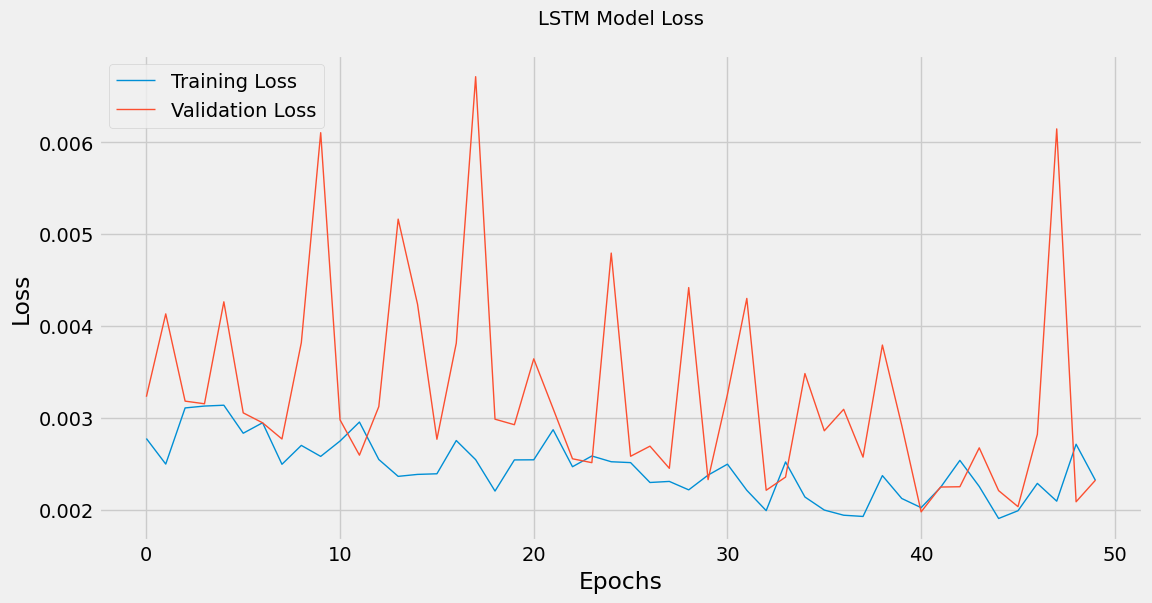

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Validation Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')

plt.grid(True)
plt.show()

In [ ]:
# Predict on the training data for LSTM2
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
# Inverse transform the predictions for LSTM2
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train)
y2_test = scaler2.inverse_transform(y2_test)

## Evaluation & Visualization

In [ ]:
# Calculate MAE for LSTM2
train_mae_close_lstm2 = mean_absolute_error(y2_train[:, 0], train_predict_lstm2[:, 0])
test_mae_close_lstm2 = mean_absolute_error(y2_test[:, 0], test_predict_lstm2[:, 0])
train_mae_kurs_lstm2 = mean_absolute_error(y2_train[:, 1], train_predict_lstm2[:, 1])
test_mae_kurs_lstm2 = mean_absolute_error(y2_test[:, 1], test_predict_lstm2[:, 1])

print(f'Training MAE (Close) LSTM2: {train_mae_close_lstm2:.4f}')
print(f'Testing MAE (Close) LSTM2: {test_mae_close_lstm2:.4f}')
print(f'\nTraining MAE (Kurs Dollar) LSTM2: {train_mae_kurs_lstm2:.4f}')
print(f'Testing MAE (Kurs Dollar) LSTM2: {test_mae_kurs_lstm2:.4f}')

Training MAE (Close) LSTM2: 154.6180
Testing MAE (Close) LSTM2: 218.8170

Training MAE (Kurs Dollar) LSTM2: 235.8715
Testing MAE (Kurs Dollar) LSTM2: 266.1867


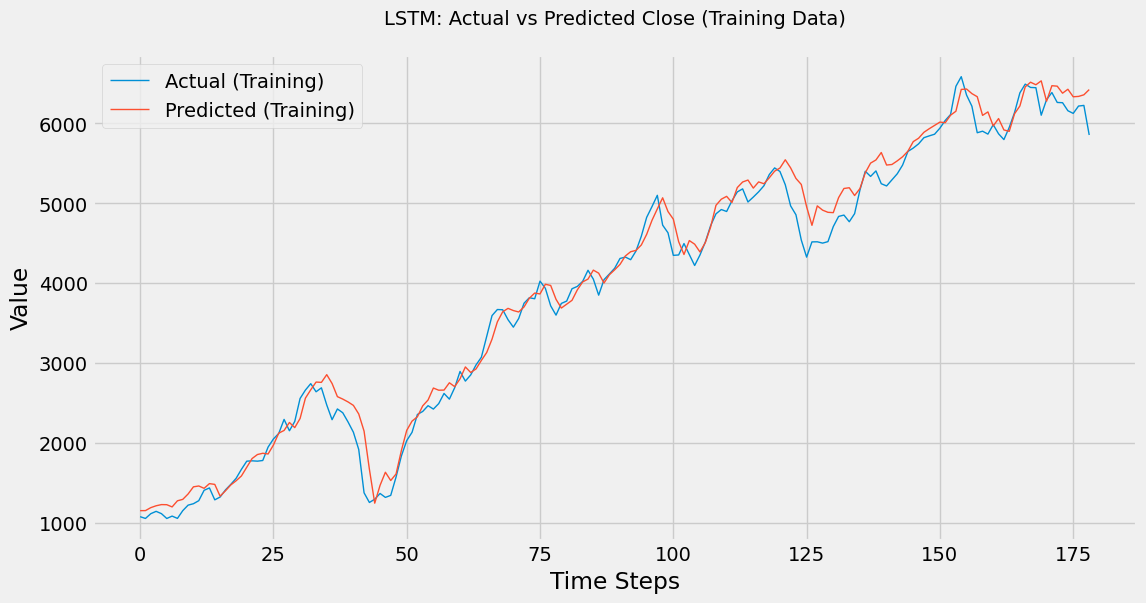

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train[:, 0], label='Actual (Training)', linewidth=1)
plt.plot(train_predict_lstm2[:, 0], label='Predicted (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Close (Training Data)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

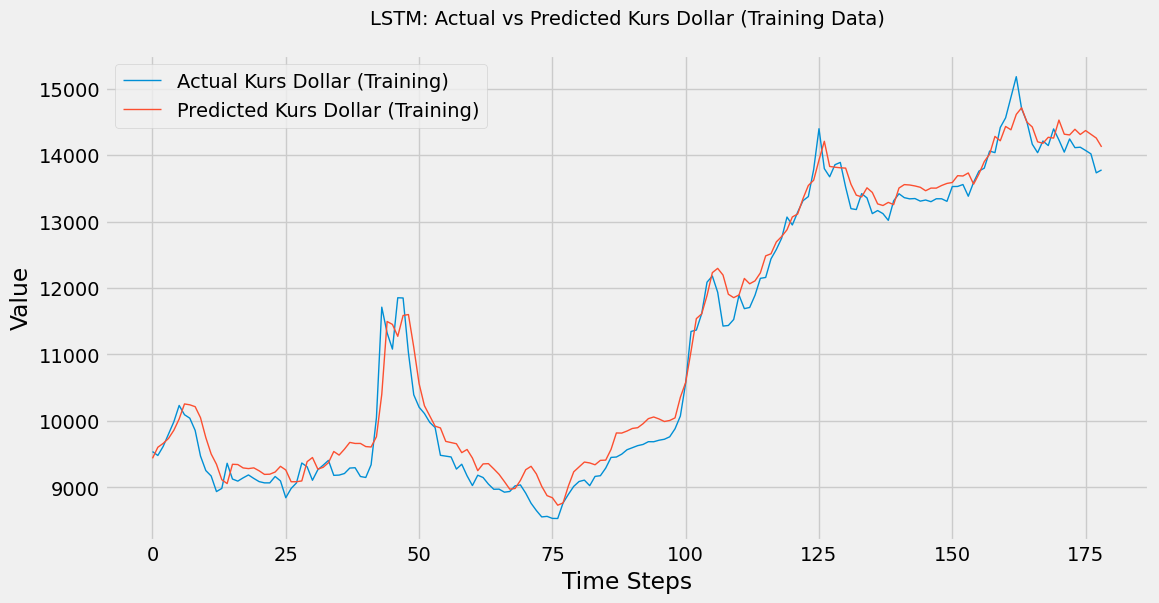

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train[:, 1], label='Actual Kurs Dollar (Training)', linewidth=1)
plt.plot(train_predict_lstm2[:, 1], label='Predicted Kurs Dollar (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Kurs Dollar (Training Data)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

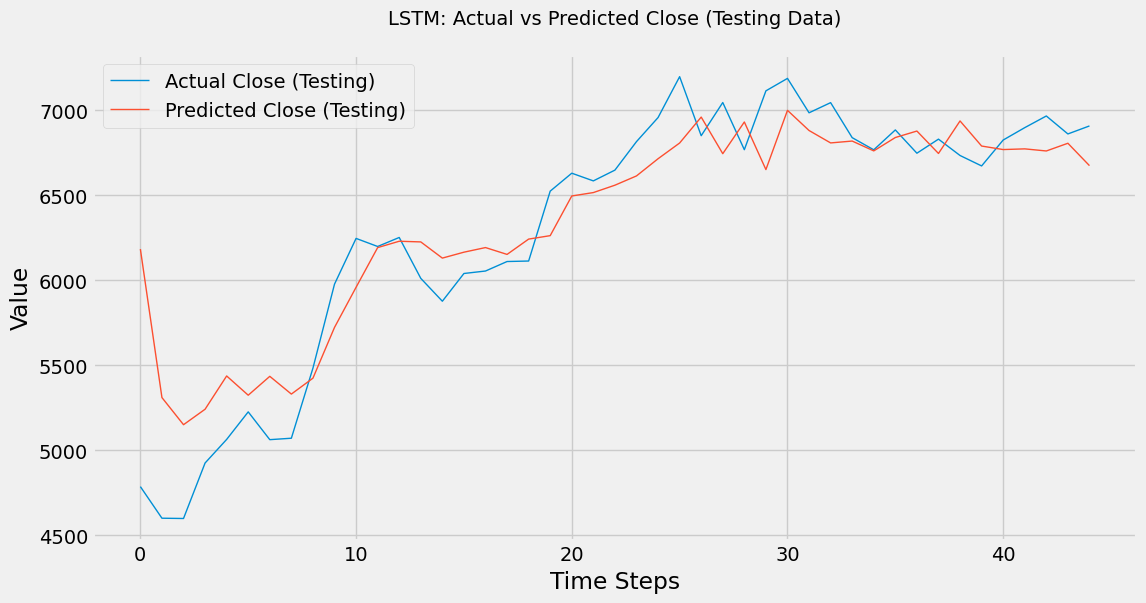

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test[:, 0], label='Actual Close (Testing)', linewidth=1)
plt.plot(test_predict_lstm2[:, 0], label='Predicted Close (Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Close (Testing Data)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

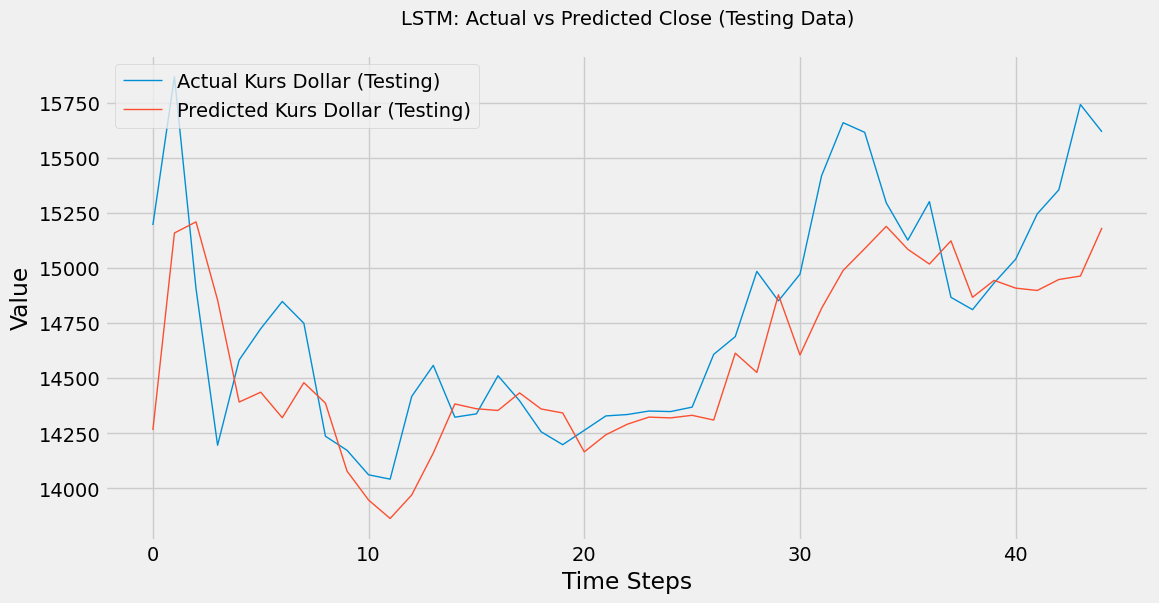

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test[:, 1], label='Actual Kurs Dollar (Testing)', linewidth=1)
plt.plot(test_predict_lstm2[:, 1], label='Predicted Kurs Dollar (Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Close (Testing Data)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting

In [ ]:
# Forecasting for the next steps
predictions_lstm2 = []
# Prepare the input data for forecasting
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, data2.shape[1])

# Loop to predict the next steps
for _ in range(7):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Close', 'Predicted Kurs Dollar'])
df_future_predictions_lstm2.index = df_update.index

df_future_predictions_lstm2

,Predicted Close,Predicted Kurs Dollar
Date,,
2024-01-31,6929.18,15055.16
2024-02-29,6965.63,14990.66
2024-03-31,6977.62,14952.70
2024-04-30,6965.84,14933.47
2024-05-31,6950.49,14919.01
2024-06-30,6934.32,14906.94
2024-07-31,6918.55,14895.76


In [ ]:
# Define true and predicted 'Close' values
y_true = df_update['Close']
y_pred = df_future_predictions_lstm2 ['Predicted Close']

# Calculate MAE for 'Close' predictions
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE) for LSTM Multivariate Close: {mae}")

Mean Absolute Error (MAE) for LSTM Multivariate Close: 251.55322140950415


In [ ]:
# Define true and predicted 'Close' values
y_true = df_update['Kurs Dollar']
y_pred = df_future_predictions_lstm2 ['Predicted Kurs Dollar']

# Calculate MAE for 'Close' predictions
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE) for LSTM Multivariate Kurs Dollar: {mae}")

Mean Absolute Error (MAE) for LSTM Multivariate Kurs Dollar: 1014.2929175634077


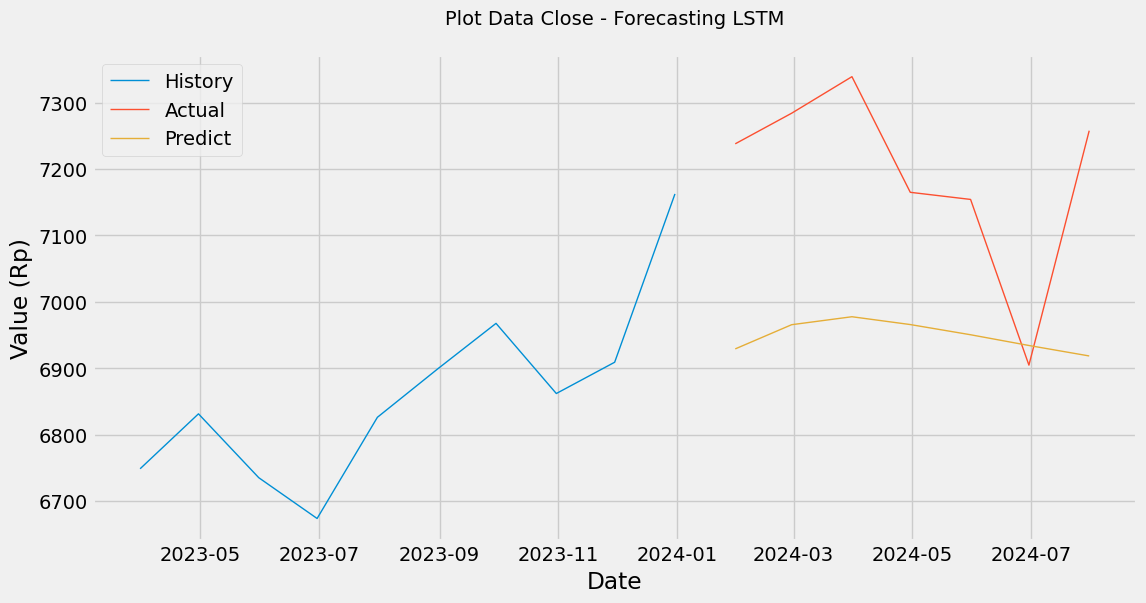

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Close'], linewidth=1, label='History')
plt.plot(df_update['Close'], linewidth=1, label='Actual')
plt.plot(df_future_predictions_lstm2['Predicted Close'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Close - Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

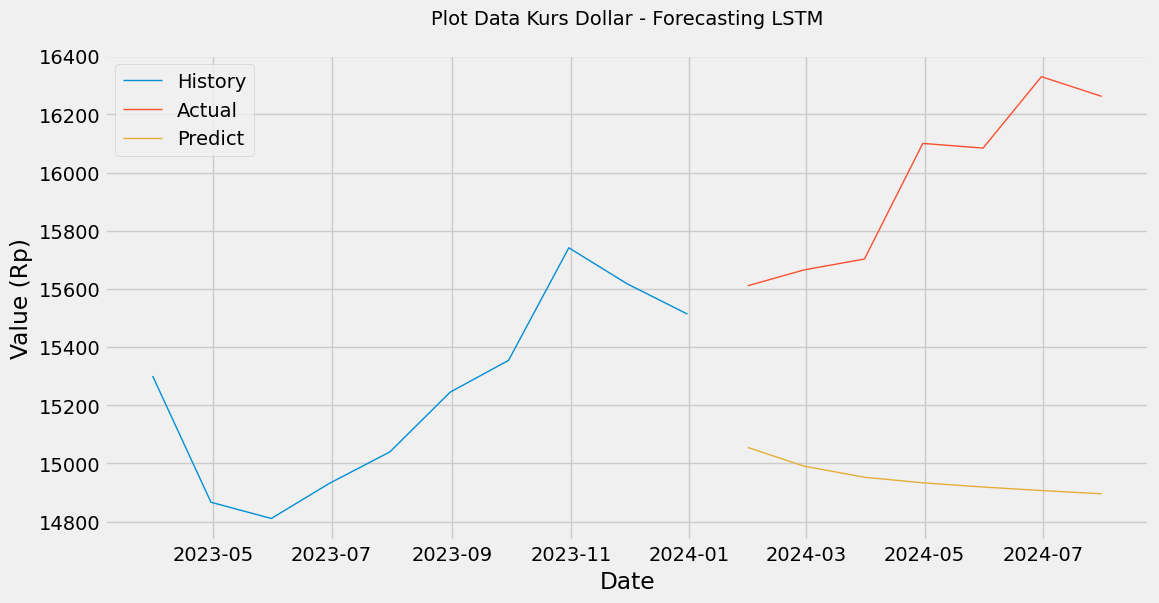

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Kurs Dollar'], linewidth=1, label='History')
plt.plot(df_update['Kurs Dollar'], linewidth=1, label='Actual')
plt.plot(df_future_predictions_lstm2['Predicted Kurs Dollar'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Kurs Dollar - Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()